cuda
Training data : 
 noisy_imgs_1 :  torch.Size([50000, 3, 32, 32]) 
 noisy_imgs_2 :  torch.Size([50000, 3, 32, 32])
Data reduced : 
 noisy_imgs_1_reduced :  torch.Size([50000, 3, 32, 32]) 
 noisy_imgs_2_reduced :  torch.Size([50000, 3, 32, 32])
Type :  torch.uint8
torch.Size([3, 32, 32])
Normalizing data ...
epoch :  1
The epoch took 20.87769341468811s to complete

epoch :  2
The epoch took 20.707112312316895s to complete

epoch :  3
The epoch took 20.68954038619995s to complete

epoch :  4
The epoch took 20.653852462768555s to complete

epoch :  5
The epoch took 20.59713912010193s to complete

epoch :  6
The epoch took 20.59159278869629s to complete

epoch :  7
The epoch took 20.58419394493103s to complete

epoch :  8
The epoch took 20.579660892486572s to complete

epoch :  9
The epoch took 20.581691026687622s to complete

epoch :  10
The epoch took 20.593819618225098s to complete



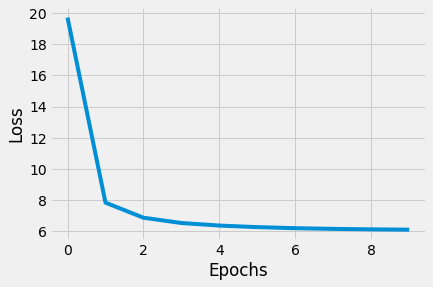

Finished training after 206.66552925109863.




------------------------------------------------
validation


Test data : 
 noisy_imgs :  torch.Size([1000, 3, 32, 32]) 
 clean_imgs :  torch.Size([1000, 3, 32, 32])
Data reduced : 
 noisy_imgs_1_reduced :  torch.Size([1000, 3, 32, 32]) 
 noisy_imgs_2_reduced :  torch.Size([1000, 3, 32, 32])
Type :  torch.uint8
torch.Size([3, 32, 32])
Normalizing data ...
torch.Size([1, 3, 32, 32])


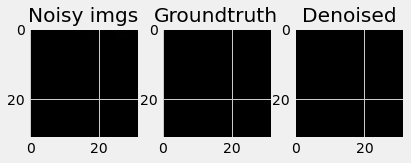

PSNR mean :  22.96417808532715  dB


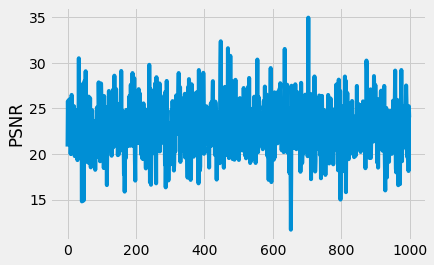

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Wed Apr 27 15:43:57 2022

@author: louis
"""
"file for colab"
import torch 
# import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

def psnr(denoised, ground_truth):
    # Peak Signal to Noise Ratio: denoised and ground ̇truth have range [0, 1]
    mse = torch.mean((denoised - ground_truth) ** 2)
    return -10 * torch.log10(mse + 10**-8)

def normalize(input):
    return (input - input.min()) / (input.max() - input.min())

class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, SIZE, train = True, NORMALIZE = False):
        'Initialization'
        if train: 
            x, y = torch.load("drive/MyDrive/Colab_Notebooks/DeepL_miniProj/train_data.pkl")
            print("Training data : \n noisy_imgs_1 : ", x.shape, "\n noisy_imgs_2 : ", y.shape)
            if SIZE > 50000:
                print("You entered a size too big, using size = 50000")
                SIZE = 50000
        else : 
            x, y = torch.load("drive/MyDrive/Colab_Notebooks/DeepL_miniProj/val_data.pkl")
            print("Test data : \n noisy_imgs : ", x.shape, "\n clean_imgs : ", y.shape)
            if SIZE > 50000:
                print("You entered a size too big, using size = 1000")
                SIZE = 1000
        x, y = x[:SIZE], y[:SIZE]
        print("Data reduced : \n noisy_imgs_1_reduced : ", x.shape, "\n noisy_imgs_2_reduced : ", y.shape)
        print("Type : ", x.dtype)
        self.x = x.float()
        self.y = y.float()
        if NORMALIZE:
            print("Normalizing data ...")
            self.x = [normalize(self.x[i]) for i in range(self.x.shape[0])]
            self.y = [normalize(self.y[i]) for i in range(self.y.shape[0])]


  def __len__(self):
        'Denotes the total number of samples'
        return len(self.x)

  def __getitem__(self, index):
        'Generates one sample of data'
        # get label
        X = self.x[index]
        Y = self.y[index]
        return X, Y
    
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(kernel_size = 2)
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, padding = 1) # 32 x 32 
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 24, kernel_size = 3, padding = 1) 
        self.conv3 = nn.Conv2d(in_channels = 24, out_channels = 48, kernel_size = 3, padding = 1) 
        self.conv4 = nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size = 3, padding = 1) 
        self.conv5 = nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size = 3, padding = 1) 
        
        self.deconv1 = nn.Conv2d(in_channels = 96, out_channels = 48, kernel_size = 3, padding = 1) 
        self.deconv2 = nn.Conv2d(in_channels = 96, out_channels = 48, kernel_size = 3, padding = 1) 
        self.deconv3 = nn.Conv2d(in_channels = 72, out_channels = 24, kernel_size = 3, padding = 1) 
        self.deconv4 = nn.Conv2d(in_channels = 40, out_channels = 16, kernel_size = 3, padding = 1) 
        self.deconv5 = nn.Conv2d(in_channels = 19, out_channels = 3, kernel_size = 3, padding = 1) 
        
        self.l_relu = nn.LeakyReLU(negative_slope = 0.1)
        self.upsample = nn.Upsample(scale_factor = (2, 2))
        self.linear = nn.Linear(32, 32)
        #self.dropout = nn.Dropout(0.5)
        
        
  
    def forward(self, x):
        # encode
        x1 = self.l_relu(self.conv1(x))
        x1 = self.l_relu(self.pool(x1))

        x2 = self.l_relu(self.conv2(x1))
        x2 = self.l_relu(self.pool(x2))

        x3 = self.l_relu(self.conv3(x2))
        x3 = self.l_relu(self.pool(x3))

        x4 = self.l_relu(self.conv4(x3))
        x4 = self.l_relu(self.pool(x4))

        x5 = self.l_relu(self.conv5(x4))
        #print(x5.shape)

        # decode
        y1 = torch.cat((x5, x4), dim = 1)
        y1 = self.l_relu(self.upsample(y1))
        y1 = self.l_relu(self.deconv1(y1))
        #print(y1.shape)

        y2 = torch.cat((y1, x3), dim = 1)
        y2 = self.l_relu(self.upsample(y2))
        y2 = self.l_relu(self.deconv2(y2))
        #print(y2.shape)

        y3 = torch.cat((y2, x2), dim = 1)
        y3 = self.l_relu(self.upsample(y3))
        y3 = self.l_relu(self.deconv3(y3))
        #print(y3.shape)

        y4 = torch.cat((y3, x1), dim = 1)
        y4 = self.l_relu(self.upsample(y4))
        y4 = self.l_relu(self.deconv4(y4))
        #print(y4.shape)

        y5 = torch.cat((y4, x), dim = 1)
        #print(y5.shape)
        y5 = self.linear(self.deconv5(y5))
        
        return y5

def plot_3imgs(denoised, ground_truth, noisy_imgs, add_title = ''): #values of the images are in between [0, 255].
    plt.subplot(1, 3, 1)
    print(noisy_imgs.shape)
    plt.imshow(torch.squeeze(noisy_imgs).permute(1, 2, 0).int()) #int since the data has been changed to float for the NN.
    plt.title("Noisy imgs")
    plt.subplot(1, 3, 2)
    plt.imshow(torch.squeeze(ground_truth).permute(1, 2, 0).int())
    plt.title("Groundtruth")
    plt.subplot(1,3,3)
    plt.imshow(torch.squeeze(denoised).permute(1, 2, 0).int())
    plt.title("Denoised")
    plt.savefig('drive/MyDrive/Colab_Notebooks/DeepL_miniProj/ae-small8/' + Losstype + add_title + '.png', dpi = 300)
    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
import torch
from datetime import datetime
import time


"""
noisy_imgs_1, noisy_imgs_2 = torch.load("train_data.pkl")
print("Training data : \n noisiy_imgs_1 : ", noisy_imgs_1.shape, "\n noisy_imgs_2 : ", noisy_imgs_2.shape)
noisy_imgs, clean_imgs = torch.load("val_data.pkl")
print("Test data : \n noisiy_imgs : ", noisy_imgs.shape, "\n clean_imgs : ", clean_imgs.shape)
noisy_imgs_1_reduced, noisy_imgs_2_reduced = noisy_imgs_1[:SIZE], noisy_imgs_2[:SIZE]
print("Training data reduced : \n noisiy_imgs_1_reduced : ", noisy_imgs_1_reduced.shape, "\n noisy_imgs_2_reduced : ", noisy_imgs_2_reduced.shape)
all_noisy_imgs = torch.cat((noisy_imgs_1_reduced, noisy_imgs_2_reduced), dim = 0)
print("Concatenated training data (reduced) : \n all_noisy_imgs : ", all_noisy_imgs.shape)
"""

SIZE = 50000
BATCH_SIZE = 128
train_set = Dataset(SIZE, NORMALIZE = True)

"""N = 20
plt.figure()
for i in range(N):
    plt.subplot(2, N, 2*i+1)
    plt.imshow(train_set.x[i].permute(1, 2, 0).int())
    plt.subplot(2, N, 2*i+2)
    plt.imshow(train_set.y[i].permute(1, 2, 0).int())
plt.show()"""


# Model Initialization
model = AE().to(device)
  
# Validation using MSE Loss function
loss_function = nn.MSELoss().to(device)
Losstype = "L1"
Losstype = "MSE"
  
# Using an Adam Optimizer with lr = 0.001
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-3, betas=(0.9, 0.99))

# DataLoader is used to load the dataset 
# for training
loader_1 = torch.utils.data.DataLoader(dataset = train_set,
                                     batch_size = BATCH_SIZE,
                                     shuffle = True)


#OPTIMIZATION
epochs = 10
outputs = []
losses = []
start_ = time.time()
for epoch in range(epochs):
    print("epoch : ", epoch + 1)
    start = time.time()
    Loss = 0
    for noisy_imgs_1, noisy_imgs_2 in loader_1:
        #print(noisy_imgs_1.shape)
        #print(noisy_imgs_2.shape)

        #noisy_imgs_1 = noisy_imgs_1.reshape(-1, 32 * 32)
        #noisy_imgs_2 = noisy_imgs_2.reshape(-1, 32 * 32)    
        # Output of Autoencoder
        #print("type : ", noisy_imgs_1.dtype)
        noisy_imgs_1 = noisy_imgs_1.to(device)
        noisy_imgs_2 = noisy_imgs_2.to(device)
        reconstructed = model(noisy_imgs_1)
            
        # Calculating the loss function
        loss = loss_function(reconstructed, noisy_imgs_2)
            
        # The gradients are set to zero,
        # the the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Storing the losses in a list for plotting
        Loss += loss.detach().cpu().numpy()
    losses.append(Loss)
    print('The epoch took {}s to complete\n'.format(time.time() - start))
    outputs.append((epochs, noisy_imgs_2, reconstructed))
  
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Epochs')
plt.ylabel('Loss')
  
plt.plot(losses)
plt.show()


Time = datetime.now().strftime('%m_%d_%Hh_%Mm_%Ss')

PATH = "drive/MyDrive/Colab_Notebooks/DeepL_miniProj/ae-small8/ae_" + Losstype + Time + ".pth" # so that we don't overwrite files
torch.save(model.state_dict(), PATH)

print('Finished training after {}.'.format(time.time() - start_))
print('\n\n\n')
print('------------------------------------------------')


#model = AE()
#time = '04_27_13h_14m_41s' # to be filled according to the job we want to load
#PATH = "./test1/project1_1_" + time + ".pth"
#model.load_state_dict(torch.load(PATH))


print("validation")
print('\n')
SIZE = 1000
BATCH_SIZE = 1
test_set = Dataset(SIZE, train = False, NORMALIZE = True)

"""plt.subplot(2, 1, 1)
plt.imshow(test_set.x[-1].permute(1, 2, 0).int())
plt.subplot(2, 1, 2)
plt.imshow(test_set.y[-1].permute(1, 2, 0).int())
plt.show()"""

loader_2 = torch.utils.data.DataLoader(dataset = test_set,
                                     batch_size = BATCH_SIZE,
                                     shuffle = False)

PSNR = torch.empty(size = (1, SIZE))
i = 0
for noisy_imgs, ground_truth in loader_2:
    noisy_imgs = noisy_imgs.to(device)
    ground_truth = ground_truth.to(device)
    denoised = model(noisy_imgs)
    Psnr = psnr(denoised.cpu(), ground_truth.cpu())
    PSNR[0, i] = Psnr
    #if Psnr > 32:
     #   plot_3imgs(denoised, ground_truth, noisy_imgs, add_title = 'good' + str(i))
    #if Psnr < 20:
     #   plot_3imgs(denoised, ground_truth, noisy_imgs, add_title = 'bad' + str(i))
    i += 1

plot_3imgs(denoised.cpu(), ground_truth.cpu(), noisy_imgs.cpu(), add_title = Time)

print("PSNR mean : ", torch.mean(PSNR).item(), " dB")
plt.style.use('fivethirtyeight')
plt.ylabel('PSNR')
plt.plot(PSNR[0,:].detach().numpy())
plt.savefig('drive/MyDrive/Colab_Notebooks/DeepL_miniProj/ae-small8/psnr_' + Losstype + Time + '.png', dpi = 300)
plt.show()